In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [2]:
# library which allows us to view model summary like keras/tf
!pip install torchsummary

In [3]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = '''
div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s;
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s;
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s;
    border-top: 2px solid %s;
}

div.input_prompt {
color: %s;
}

div.output_prompt {
color: %s; 
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s;
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s;
}

.edit_mode div.cell.selected:before {
background: %s;
}

.edit_mode div.cell.selected {
border-color: %s;

}
'''

def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, 
                                            main_color,  main_color, prompt, main_color, main_color, 
                                            main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()


![](https://i.imgur.com/0oW3bQA.png)

## <b>1 <span style='color:#F1A424'>|</span> Introduction</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>1.1 |</span></b> Why do we need this study?</b></p>
</div>

- Microscopic evaluation of histopathalogic stained tissue & its subsequent digitalisation is now a more feasible due to the advances in slide scanning technology, as well a reduction in digital storage cost in recent years
- There are certain advantages that come with such digitalised pathology; including remote diagnosis, instant archival access & simplified procedure of consultations with expert pathologists
- Digitalised Analysis based on Deep Learning has shown potential benefits as a potential diagnosis tool & strategy
- [Gulshan et al](https://jamanetwork.com/journals/jama/fullarticle/2588763) and [Esteva et al](https://pubmed.ncbi.nlm.nih.gov/28117445/) demonstrated the <b>potential of deep learning for diabetic retinopathy screening</b> and <b>skin lesion classification</b>, respectively
- An essential task performed by pathologist; accurate breast cancer staging 
- Assessment of the extent of cancer spread by histopathological analysis of sentinel axillary lymph nodes (SLNs) is an essential part of breast cancer staging process

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>1.2 |</span></b> Problem Statement</b></p>
</div>

- The sensitivity of SLN assessment by pathologists, however, is not optimal. A retrospective study showed that pathology review by experts changed the nodal status in 24% of patients.
- SLN assessment is <b>tedious</b> and <b>time-consuming</b>. It has been shown that deep learning algorithms could identify metastases in SLN slides with 100% sensitivity, whereas 40% of the slides without metastases could be identified as such
- This could result in a <b>significant reduction in the workload</b> of pathologists

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>1.3 |</span></b> Study Aim</b></p>
</div>

The aim of this study was to investigate the potential of using **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">PyTorch</mark>** Deep Learning module:
  - For the <b>detection of metastases</b> in SLN slides and compare them with the predefined pathologist diagnosis.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>1.4 |</span></b> Playground Prediction Competition</b></p>
</div>

#### **<span style='color:#F1A424'>OVERVIEW</span>**

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

> [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

#### **<span style='color:#F1A424'>SUBMISSION FORMAT</span>**

For each id in the test set:
 - You must predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue. 
 - The file should contain a header and have the following format: 

id,label <br>
<code>0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0</code>

## <b>2 <span style='color:#F1A424'>|</span> Dataset</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>2.1 |</span></b> Load Dataset</b></p>
</div>

- Load the dataset information file; <code>train_labels.csv</code>, it contains a reference to an image ID (id) & its classification allocation (label)

In [4]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(labels_df.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [5]:
os.listdir('/kaggle/input/histopathologic-cancer-detection/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [6]:
labels_df.shape

(220025, 2)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>2.2 |</span></b> Check for duplicate entries</b></p>
</div>

- Check if the dataset contains any duplicates, if there is we should drop them, which we have none

In [7]:
# No duplicate ids found
labels_df[labels_df.duplicated(keep=False)]

,id,label


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>2.3 |</span></b> Target feature class balance</b></p>
</div>

Definitely not as one sides as was expected:
- The dataset favours **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">non- malignant</mark>**, normal cases (13k) 
- compared to **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">non-malignant</mark>** cases (8.9k)

In [8]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>2.4 |</span></b> Dataset preview</b></p>
</div>

Let's also visualise the dataset images:
- **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">non-malignant</mark>** cases (0) (outligned with green colour)
- **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">malignant</mark>** cases (1) (outligned with red colour)


- We can note that its quite a **<span style='color:#F1A424'>challenge to distinguish</span>** whether an image should be classified as **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">malignant</mark>** or **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">non-malignant</mark>** simply from an inspection


- An **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">expert evaluation</mark>** is quite beneficial: 
    - However it is likely a very **<span style='color:#F1A424'>time consuming procedure</span>** as indicated in the introduction

In [9]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/" # training data is stored in this folder
malignant = labels_df.loc[labels_df['label']==1]['id'].values    # get the ids of malignant cases
normal = labels_df.loc[labels_df['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [10]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

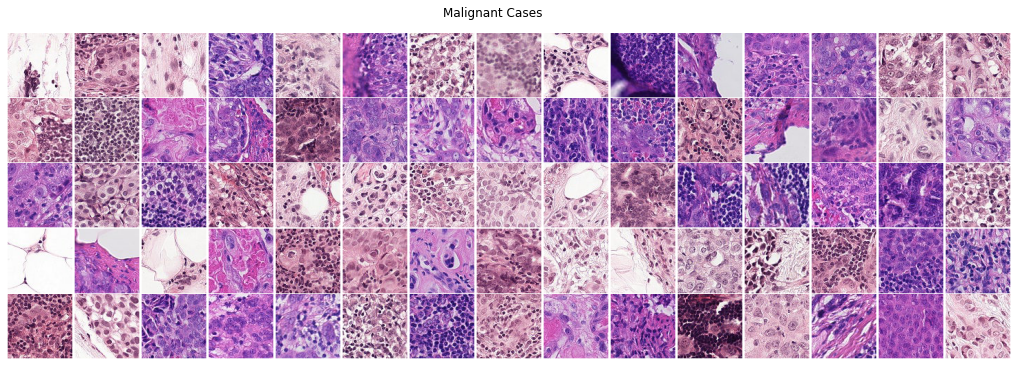

In [11]:
plot_fig(malignant,'Malignant Cases')

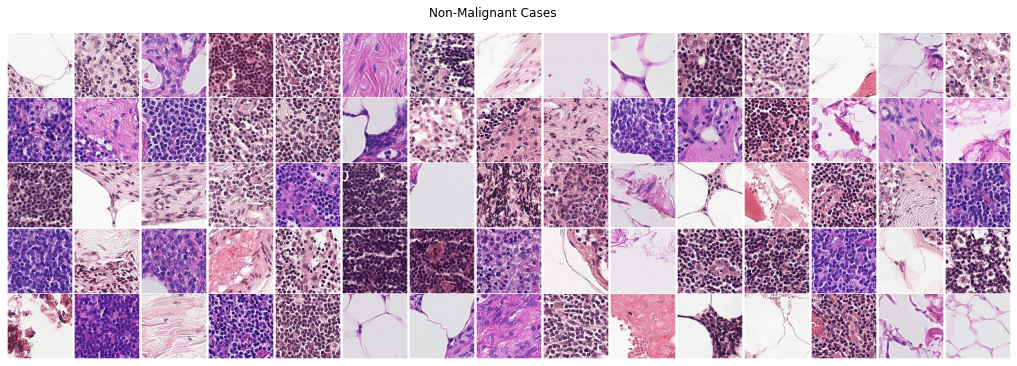

In [12]:
plot_fig(normal,'Non-Malignant Cases')

## <b>3 <span style='color:#F1A424'>|</span> Data Preparation</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>3.1 |</span></b> Custom dataset class</b></p>
</div>

- Let's create a custom <code>Dataset</code> class by subclassing the <code>Pytorch Dataset</code> class:
    - We need just two essential fuctions <code>__len__</code> & <code>__getitem__</code> in our custom class       
- To speed up the training process, were using only 4000 samples for the entire dataset (

In [13]:
torch.manual_seed(0) # fix random seed

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files
        
        file_names = os.listdir(cdm_data) # get list of images in that directory  
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      4000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images
        
        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  # obtained labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]


In [14]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [15]:
# Define an object of the custom dataset for the train folder.
data_dir = '/kaggle/input/histopathologic-cancer-detection/'
img_dataset = pytorch_data(data_dir, data_transformer, "train") # Histopathalogic images

In [16]:
# load an example tensor
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 46, 46]) tensor(0.2047) tensor(1.)


## <b>4 <span style='color:#F1A424'>|</span> Splitting the Dataset</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>4.1 |</span></b> random_split</b></p>
</div>

- Among the training set, we need to evaluate the model on validation datasets to track the model's performance during training.
- Let's use 20% of img_dataset for **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">validation</mark>** & use the rest as the **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">training</mark>** set, so we have a 80/20 split

In [17]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 3200
validation dataset size: 800


In [18]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0


In [19]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>4.2 |</span></b> Training subset examples</b></p>
</div>

- Some examples from our training data subset, with corresponding labels.

image indices: [2450 2662 2616 1205  959 2016 2219 3054  447 2775 3063  377 3072  736
 2961 3147 1171  556 1261 2149 2668 2321 2040 2850   91 2925   27  999
 2920 1831]
torch.Size([3, 146, 482])



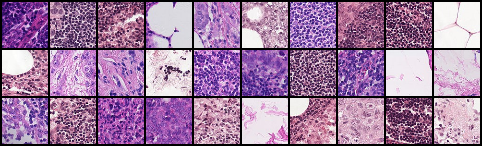

In [20]:
# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>4.3 |</span></b> Validation subset examples</b></p>
</div>

- Some examples from the validation subset, with corresponding labels.

image indices: [587 610 780 732 539 152  93  40 251 551 595 275 331  88 278 489 190 563
 183  61 781  97 355 377 661 798 754  32 500 693]
torch.Size([3, 146, 482])



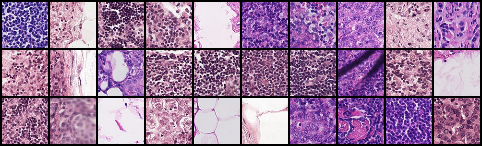

In [21]:
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

## <b>5 <span style='color:#F1A424'>|</span> Image Augmentation Definitions</b> 

#### **<span style='color:#F1A424'>IMAGE AUGMENTATIONS</span>**

- Among with pretrained models, image __transformation__ and __image augmentation__ are generally considered to be an essential parts of constructing deep learning models.
- Using image transformations, we can expand our dataset or resize and normalise it to achieve better model performance.
- Typical transformations include __horizontal__,__vertical flipping__, __rotation__, __resizing__.
- We can use various image transformations for our binary classification model without making label changes; we can flip/rotate a __malignant__ image but it will remain the same, __malignant__.
- We can use the torchvision module to perform image transformations during the training process.

#### **<span style='color:#F1A424'>TRAINING DATA AUGMENTATIONS</span>**
- transforms.RandomHorizontalFlip(p=0.5): Flips the image horizontally with the probability of 0.5
- transforms.RandomVerticalFlip(p=0.5) : Flips the image vertically  " 
- transforms.RandomRotation(45) : Rotates the images in the range of (-45,45) degrees.
- transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)) : Randomly square crops the image in the range of [72,96], followed by a resize to 96x96, which is the original pixel size of our image data.
- transforms.ToTensor() : Converts to Tensor & Normalises as shown above already.

In [22]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [23]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

## <b>6 <span style='color:#F1A424'>|</span> Creating Dataloaders</b> 

- Ready to create a PyTorch Dataloader. If we don't use __Dataloaders__, we have to write code to loop over datasets & extract a data batch; automated.
- We need to define a __batch_size__ : The number of images extracted from the dataset each iteration

In [24]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [25]:
# check samples
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 46, 46]) tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0])


## <b>7 <span style='color:#F1A424'>|</span> Define Binary Classifier</b> 

- Model is comprised of:
  - **<span style='color:#F1A424'>four CNN</span>** **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">Conv2D</mark>** layers with a **<span style='color:#F1A424'>pooling layer</span>** **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">max_pool2D</mark>** added between each layer 
  - Two **<span style='color:#F1A424'>fully connected</span>** layers **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">fc</mark>**, with a **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">dropout</mark>** layer between the two layers
  - **<span style='color:#F1A424'>log_softmax</span>** is used as the activation function for the final layer of the **<span style='color:#F1A424'>binary classifier</span>**
  
  
- PyTorch allows us to create a custom class with <code>nn.Module</code>


In [26]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [27]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [28]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


## <b>8 <span style='color:#F1A424'>|</span> Loss Function Definition</b> 

- Loss Functions are one of the key pieces of an effective deep learning solution.
- Pytorch uses <code>loss functions</code> to determine how it will update the network to reach the desired solution.
- The standard loss function for classification tasks is __cross entropy loss__ or __logloss__
- When defining a loss function, we need to consider, the number of model outputs and their activation functions.
- For binary classification tasks, we can choose one or two outputs.
- It is recommended to use __log_softmax__ as it is easier to expand to multiclass classification; PyTorch combines the log and softmax operations into one function, due to numerical stability and speed.

In [29]:
loss_func = nn.NLLLoss(reduction="sum")

## <b>9 <span style='color:#F1A424'>|</span> Optimiser Definition</b> 

- Training the network involves passing data through the network:
    - Using the **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">loss function</mark>** to **<span style='color:#F1A424'>determine the difference between the prediction & true value</span>**
    - Which is then followed by using of that info to **<span style='color:#F1A424'>update the weights</span>** of the network 
    - In an attempt to **<span style='color:#F1A424'>make the loss function return as small of a loss as possible, performing updates on the neural network</span>**, an **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">optimiser</mark>** is used
- The <code>torch.optim</code> contains implementations of common optimisers
- The **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">optimiser</mark>** will **<span style='color:#F1A424'>hold the current state and will update the parameters based on the computed gradients</mark>**
- For binary classification taskss, __SGD__, __Adam__ Optimisers are commonly used, let's use the latter here.

In [30]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>10 <span style='color:#F1A424'>|</span> Training Model</b> 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>10.1 |</span></b> Helper functions</b></p>
</div>

The main training loop function <code>train_val</code> will utiliser three functions:
- <code>get_lr</code> : get the learning rate as it is adjusted 
- <code>loss_batch</code> : get the loss value for the particular batch
- <code>loss_epoch</code> : get the entire loss for an epoch iteration

In [31]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [32]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>10.2 |</span></b> Main training function</b></p>
</div>

`train_val` is the main function used to train the model on the **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">training set</mark>** `train_dl` & evaluate on the **<mark style="background-color:#F1C40F;color:white;border-radius:5px;opacity:0.9">validation set</mark>** `val_dl`

#### **<span style='color:#F1A424'>FUNCTION INPUTS</span>**

The function requires
- **<span style='color:#F1A424'>PyTorch Classifier</span>** , `cnn_model` (we visualised in section 7)
- Training **<span style='color:#F1A424'>parameter dictionary</span>** `params_train` (which contains both hyperparameters & input data)

#### **<span style='color:#F1A424'>FUNCTION PARAMETER DICTIONARY</span>**

The parameter dictionary requires:
- Number of training **<span style='color:#F1A424'>iterations</span>**,`epochs`
- Training & validation **<span style='color:#F1A424'>data loaders</span>**, `train_dl`, `val_dl`
- **<span style='color:#F1A424'>Optimiser</span>** & **<span style='color:#F1A424'>loss function</span>**,  `opt` & `loss_func`
- **<span style='color:#F1A424'>Learning rate adjustor</span>** (on the fly) `lr_change`

#### **<span style='color:#F1A424'>POST TRAINING OUTPUT</span>**

`train_val` returns:
- The best performing model on the validation dataset
- The Loss per iteration
- The Evaluation Metric per iteration (which is accuracy)

In [33]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#F1A424'>10.3 |</span></b> Training Process </b></p>
</div>

#### **<span style='color:#F1A424'>SET PARAMETER DICTIONARY</span>**

- Define the parameters for training `params_train` & train classifier
- We'll be training the classifier for **<span style='color:#F1A424'>50 iterations</span>** using the **<span style='color:#F1A424'>Adam optimiser</span>** & the **<span style='color:#F1A424'>negative log likelihood loss</span>** function
- The learning rate will be adjusted on the fly using `ReduceLROnPlateau`, with a factor of 1/2

In [34]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

#### **<span style='color:#F1A424'>LOSS & EVALUATION METRIC VISUALISATION</span>**

Let's visualise the performance of the model on the sample dataset 

Text(0.5, 1.0, 'Convergence History')

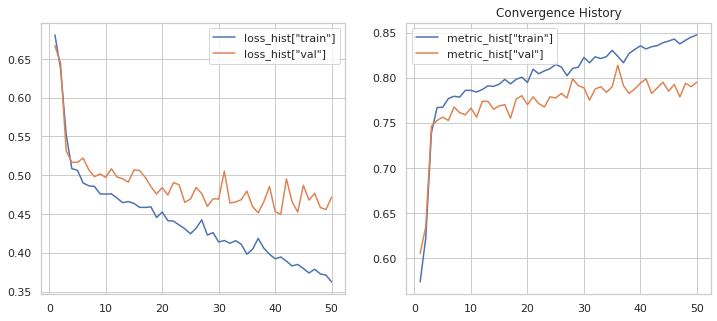

In [35]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

In [36]:
# # Train-Validation Progress
# epochs=params_train["epochs"]

# fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
# fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["train"],name='loss_hist["train"]'),row=1, col=1)
# fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["val"],name='loss_hist["val"]'),row=1, col=1)
# fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["train"],name='metric_hist["train"]'),row=1, col=2)
# fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["val"],name='metric_hist["val"]'),row=1, col=2)
# fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
# fig.show()

## <b>11 <span style='color:#F1A424'>|</span> Inference</b> 

- Once we have trained our model using `train_val`, we can begin to utilise it to **<span style='color:#F1A424'>make some predictions</span>**
- We have a whole dataset of **<span style='color:#F1A424'>unlabelled image</span>** data in folder test
- The unique ids of each image in the dataset are located in file `sample_submission.csv`
- Like for thr training dataset, well create a data loader, using only tensor transformation
- As we have no label data, we need a slightly modified data class

In [37]:
class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

#### **<span style='color:#F1A424'>CHECKS</span>**

- Confirm our best performing model has been saved in the working directory 
- Confirm the test folder contents are present

In [38]:
!ls

__notebook__.ipynb  notebook.css  weights.pt


In [39]:
!ls '/kaggle/input/histopathologic-cancer-detection/test' | head -n 5

00006537328c33e284c973d7b39d340809f7271b.tif
0000ec92553fda4ce39889f9226ace43cae3364e.tif
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
000270442cc15af719583a8172c87cd2bd9c7746.tif
ls: write error: Broken pipe


#### **<span style='color:#F1A424'>FUNCTION PARAMETER DICTIONARY</span>**

Having defined a model architecture, we can load model weights

In [40]:
# load any model weights for the model
cnn_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

#### **<span style='color:#F1A424'> TEST FILE IDS</span>**

The submission file contains all the ids to the files that are located in the test folder

In [41]:
# sample submission
path_sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape

(57458, 2)

#### **<span style='color:#F1A424'>TEST IMAGE DATASET</span>**

Like we did with the training set, lets convert and store all image data in 

In [42]:
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

57458 samples found


#### **<span style='color:#F1A424'>PREDICTION FUNCTION</span>**

For inference, we need to set the model to `torch.no_grad`



In [43]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt            

In [44]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device)            

  0%|          | 0/57458 [00:00<?, ?it/s]

In [45]:
# class predictions 0,1
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(57458,)
[0 0 0 1 0]


In [46]:
# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[0:5])

(57458,)
[0.20131248 0.08253237 0.17993395 0.8466662  0.35621664]
